<a href="https://colab.research.google.com/github/i2ohan/DropBox/blob/main/Stock_Market_Analytics_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs
import requests

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [4]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import yfinance as yf
prices = yf.download(tickers, start='2020-01-01')['Adj Close'] 

[*********************100%***********************]  500 of 500 completed


In [6]:
rs = prices.apply(np.log).diff(1)

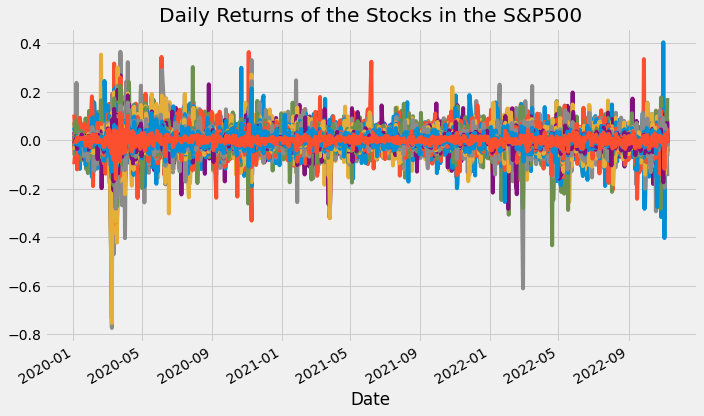

In [7]:
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

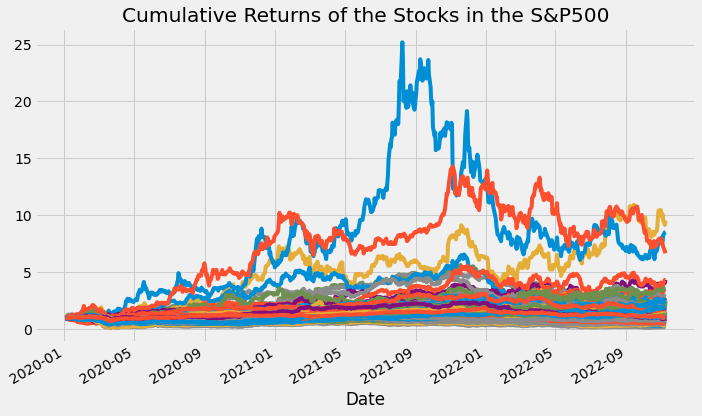

In [8]:
(rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(1).fit(rs.fillna(0))

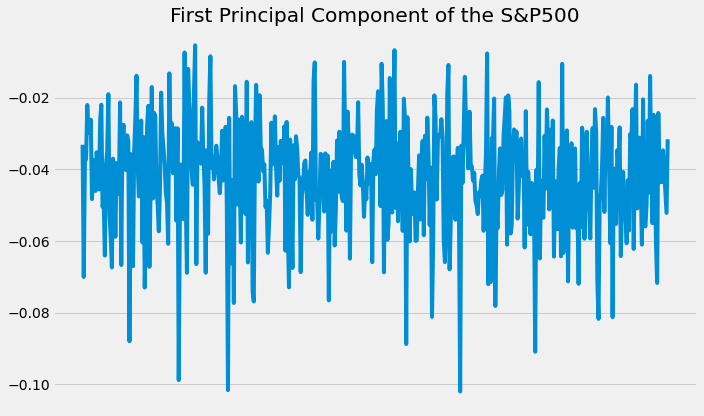

In [11]:
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

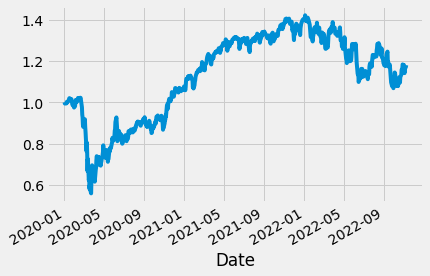

In [12]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()

In [13]:
prices = yf.download(['SPY'], start='2020-01-01')['Adj Close'] 

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


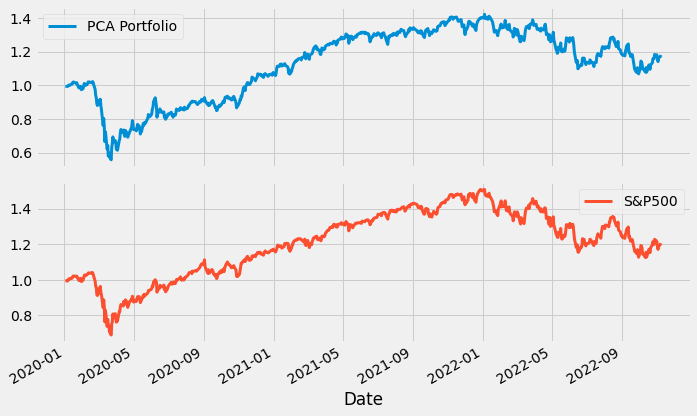

In [14]:
rs_df = pd.concat([myrs, prices.apply(np.log).diff(1)], 1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()
plt.savefig('tmp.png')

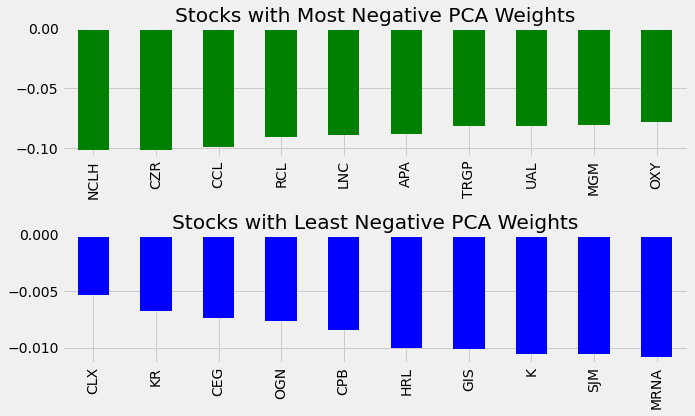

In [15]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()
plt.savefig('tmp.png')

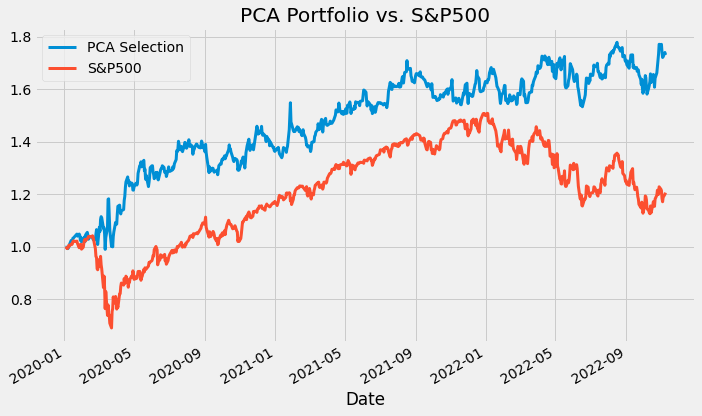

In [16]:
# ws = [-1,]*10+[1,]*10
# myrs = (rs[list(pc1.nsmallest(10).index)+list(pc1.nlargest(10).index)]*ws).mean(1)
myrs = rs[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')